<a href="https://colab.research.google.com/github/pena-rodrigo/golombCA1/blob/main/single_thetagamma_NMDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Created on Mar 2 2022
"""

import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "DejaVu Sans"
import pandas as pd
import time
from scipy import signal
from scipy import stats
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import seaborn as sns
import random
import pylab
pylab.rcParams['savefig.dpi'] = 120
#matplotlib inline

# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/images'

Mounted at /content/gdrive


In [ ]:
""" Parameters simulation """
dt = 0.01 # 0.05, OLM only works for 0.01
tf = 800
N  = round(tf/dt)
D  = 0.1

In [ ]:
"""stim functions"""

Ipoisson = lambda r: 1*(np.random.rand()<r*10**-3*dt)
Izap = lambda i, Fzap, A: A*np.sin(2*np.pi*Fzap*10**-3*i*dt + 3*np.pi/2)

def rect(T):
    """create a centered rectangular pulse of width $T"""
    return lambda t: (-T/2 <= t) & (t < T/2)

def pulse_train(t, at, shape):
    """create a train of pulses over $t at times $at and shape $shape"""
    return np.sum(shape(t - at[:,np.newaxis]), axis=0)

In [ ]:
#@title HHca2
class HHca2:
    """Golomb model with Ca + second compartment with I_h"""
    nid=0 #default neuron id
    sendspk=0
    
    C = 1
    Gl=0.05
    Vl = -70
    Gna = 35
    Gnap = 0.3 #varies between 0 and 0.41 mS/cm2
    thetam = -30
    deltam = 9.5
    Vna = 55
    Gkdr = 6
    thetah = -45
    deltah = -7
    thetaht= -40.5
    deltaht= -6
    Vk = -90
    thetap = -47 #-47#-41 #varies between -47mV and -41mV
    deltap = 3
    thetan = -35
    deltan = 10
    thetant =-27
    deltant=-15
    Ga = 1.4
    thetaa = -50
    deltaa = 20
    taub = 15
    thetab = -80
    deltab = -6
    Gm = 1
    tauz = 75
    thetaz = -39
    deltaz = 5
    
    Gca = 0.2#0.#0*0.2 #varies between 0 and 0.2 mS/cm2
    Gc = 10
    Gsahp = 5
    Vca = 120
    thetar=-20
    deltar=10
    taur=1
    thetac=-30
    deltac=7
    tauc=2
    ac=6
    tauq=450
    aq=2
    
    nu=0.13
    tauca=13
    
    Iapp = 0.9
    Inoise=0.0

    Vnmda=0
    Gnmda=0.08*1e4
    ar=0.072
    ad=0.0066
    Tjump=0

    """second compartment parameters"""
    Gl2 = Gl
    Gh2 = 2.
    Vh2 = -32.9
    Iapp2 = 0.9

    """couplings between compartments"""
    Gsd = 0.2
    Gds = 0.2
    
    D = 0.0   
    Dz = .5e-5
    
    Ein=-80.
    Eex=0.
    Gie=0.08
    Goe=5*0.08#0.15
    tauR_ampa = 0.1
    tauD_ampa = 3.0
    tauR_gaba = 0.2
    tauD_gaba = 20.

    vth= 0#-20
    Iin = 0
    Iin2 = 0

    countdelay=0
    countdelay2=0
    
    spktimes = []

    gext = 8 #ext
    tauext=10 #ext

    gextdend = 8 #ext
    tauextdend=10 #ext

    
    def __init__(self,nid=1,D=0.1,Gnap=0.3,Ca_acum=0.0001, No = 1.0, Ni=1.0, Dz=.5e-5):
        self.Gie = self.Gie/Ni
        self.Goe = self.Goe/No
        self.minf= lambda V:  1.0/(1+np.exp(-(V-self.thetam)/self.deltam))
        self.hinf= lambda V:  1.0/(1+np.exp(-(V-self.thetah)/self.deltah))
        self.tauh= lambda V:  0.1 + 0.75*(1.0/(1+np.exp(-(V-self.thetaht)/self.deltaht)))
        self.ninf= lambda V:  1.0/(1+np.exp(-(V-self.thetan)/self.deltan))
        self.taun= lambda V:  0.1 + 0.5*(1.0/(1+np.exp(-(V-self.thetant)/self.deltant)))
        self.pinf= lambda V:  1.0/(1+np.exp(-(V-self.thetap)/self.deltap))
        self.ainf= lambda V:  1.0/(1+np.exp(-(V-self.thetaa)/self.deltaa))
        self.binf= lambda V:  1.0/(1+np.exp(-(V-self.thetab)/self.deltab))
        self.zinf= lambda V:  1.0/(1+np.exp(-(V-self.thetaz)/self.deltaz))
        
        self.rinf= lambda V:  1.0/(1+np.exp(-(V-self.thetar)/self.deltar))
        self.cinf= lambda V:  1.0/(1+np.exp(-(V-self.thetac)/self.deltac))
        self.dinf= lambda Ca_acum:  1.0/(1+self.ac/Ca_acum)
        self.qinf= lambda Ca_acum:  1.0/(1+(self.aq**4)/(Ca_acum**4))

        """for h-current of dendrite"""
        self.h2_inf = lambda V: 1./(1. + np.exp((V + 84.)/10.2))
        self.tauh2 = lambda V: 1./(np.exp(-17.9 - 0.116*V ) + np.exp(-1.84 + 0.09*V )) + 0.1

        self.Nv = lambda V: ( 1+np.tanh((V)/4.0) )#/2.
        self.Nv2 = lambda V: ( 1+np.tanh((V)/4.0) )#/2.
        
        self.nid = nid
        self.Dz = Dz
        self.D = D      
        self.v = -72.#-89.09
        self.h = 0
        self.n = 0
        self.b = 0
        self.z = 0       
        self.s = 0
        self.sie=0
        self.soe=0
        self.r=0
        self.c=0
        self.Ca_acum= Ca_acum #
        self.Gnap= Gnap
        self.q=0

        self.sext = 0 #external current
        self.sextdend = 0
        self.snmda = 0
        
        """second compartment variables"""
        self.v2 = -72.
        self.h2 = 0
        self.s2 = 0
        
        self.spktimes = []
        
    def _UpdateKs(self,v,h,n,b,z,r,c,Ca_acum,q,s,v2,h2,s2,sext,sextdend, snmda, stim, stim2):
        Isyn = self.Gie*self.sie*(v-self.Ein)
        self.Iin = Isyn

        Isyn2 = self.Gie*self.soe*(v2-self.Ein)
        self.Iin2 = Isyn2

        Iext = self.gext*sext * (v-self.Ein) #added to the soma
        Iextdend = self.gextdend*sextdend * (v-self.Ein) #added to the dendrite
        """Ext inputs"""
        ksext = -sext/self.tauext
        ksextdend = -sextdend/self.tauextdend

        """NMDA"""
        B = lambda vin: 1. / (1. + np.exp((-vin-10)/16.13))
        #At the physiological concentration of2mM, VT ≈−10mV (Ermentrout)
        Inmda = self.Gnmda * snmda * B(v) * (v - self.Vnmda)

        
        """somatic currents"""
        Il = self.Gl * (v - self.Vl)
        Ina  = self.Gna * (self.minf(v)**3) * h *(v-self.Vna)
        Inap = self.Gnap * self.pinf(v) * (v-self.Vna)
        Ikdr = self.Gkdr * (n**4) * (v-self.Vk) 
        IA   = self.Ga * (self.ainf(v)**3) * b * (v-self.Vk)
        IM   = self.Gm * z * (v-self.Vk)
        
        Ica  = self.Gca * (r**2) * (v-self.Vca) 
        Ic   = self.Gc * self.dinf(Ca_acum) * c * (v-self.Vk)
        Isahp= self.Gsahp * q * (v-self.Vk)

        """conection between v and v2"""
        Isd = self.Gsd*(v2-v)
        Ids = self.Gds*(v-v2)

        """h-current term for v2"""
        Il2 = self.Gl2 * (v2- self.Vl)
        Ih2 = self.Gh2 * h2 * (v2- self.Vh2)
        
        Itotal =  self.Iapp - Il - Ina - Inap - Ikdr - IA - IM - Ica - Ic - Isahp - Isyn + Isd  + stim - Iext 
        Itotal2 = self.Iapp2 - Il2 - Ih2 - Isyn2 + Ids + stim2 - Iextdend - Inmda

        kv = Itotal / (self.C)
        kh = (self.hinf(v)-h)/self.tauh(v)
        kn = (self.ninf(v)-n)/self.taun(v)
        kb = (self.binf(v)-b)/self.taub
        kz = (self.zinf(v)-z)/self.tauz     
        
        kr = (self.rinf(v)-r)/self.taur  
        kc = (self.cinf(v)-c)/self.tauc
        kCa_acum = -self.nu*Ica - Ca_acum/self.tauca
        kq = (self.qinf(Ca_acum)-q)/self.tauq
        
        ks = self.Nv(v)*(1-s)/self.tauR_ampa - s/self.tauD_ampa
        ks2 = self.Nv2(v2)*(1-s2)/self.tauR_ampa - s2/self.tauD_ampa

        """v2 compartment"""
        kv2 = Itotal2 / (self.C)
        kh2 = (self.h2_inf(v2)-h2)/self.tauh2(v2)

        ksnmda = self.ar*self.Tjump*(1-snmda)-self.ad*snmda
        

        return kv, kh, kn, kb, kz, kr, kc, kCa_acum, kq, ks, kv2, kh2, ks2, ksext, ksextdend, ksnmda

    def _Updatev(self,stim,stim2,sie,soe,dt,time):
        self.sie = sie
        self.soe = soe
        #if(self.countdelay>0):
        #    self.countdelay-=dt
        #if(self.countdelay<0):
        #    self.countdelay=0
        #    self.s += 1
        """for second compartment""" #that is used for something?
        #if(self.countdelay2>0):
        #    self.countdelay2-=dt
        #if(self.countdelay2<0):
        #    self.countdelay2=0
        #    self.s2 += 1
  
        k1v, k1h, k1n, k1b, k1z, k1r, k1c, k1Ca_acum, k1q, k1s, k1v2, k1h2, k1s2, k1sext, k1sextdend, k1snmda = self._UpdateKs(self.v,self.h,self.n,self.b,self.z,self.r,self.c,self.Ca_acum,self.q,self.s,self.v2,self.h2,self.s2,self.sext,self.sextdend,self.snmda,stim,stim2)
        a_v= self.v + k1v*dt/2
        a_h= self.h + k1h*dt/2
        a_n= self.n + k1n*dt/2
        a_b= self.b + k1b*dt/2
        a_z= self.z + k1z*dt/2
        a_r= self.r + k1r*dt/2
        a_c= self.c + k1c*dt/2
        a_Ca_acum= self.Ca_acum + k1Ca_acum*dt/2
        a_q= self.q + k1q*dt/2
        a_s= self.s + k1s*dt/2
        a_v2 = self.v2 + k1v2*dt/2
        a_h2 = self.h2 + k1h2*dt/2
        a_s2 = self.s2 + k1s2*dt/2
        a_sext= self.sext + k1sext*dt/2
        a_sextdend= self.sextdend + k1sextdend*dt/2
        a_snmda= self.snmda + k1snmda*dt/2        

        k2v, k2h, k2n, k2b, k2z, k2r, k2c, k2Ca_acum, k2q, k2s, k2v2, k2h2, k2s2, k2sext, k2sextdend, k2snmda = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,a_snmda,stim,stim2)
        a_v= self.v + k2v*dt/2
        a_h= self.h + k2h*dt/2
        a_n= self.n + k2n*dt/2
        a_b= self.b + k2b*dt/2
        a_z= self.z + k2z*dt/2
        a_r= self.r + k2r*dt/2
        a_c= self.c + k2c*dt/2
        a_Ca_acum= self.Ca_acum + k2Ca_acum*dt/2
        a_q= self.q + k2q*dt/2
        a_s= self.s + k2s*dt/2
        a_v2 = self.v2 + k2v2*dt/2
        a_h2 = self.h2 + k2h2*dt/2
        a_s2 = self.s2 + k2s2*dt/2
        a_sext= self.sext + k2sext*dt/2
        a_sextdend= self.sextdend + k2sextdend*dt/2
        a_snmda= self.snmda + k2snmda*dt/2    

        k3v, k3h, k3n, k3b, k3z, k3r, k3c, k3Ca_acum, k3q, k3s, k3v2, k3h2, k3s2, k3sext, k3sextdend, k3snmda = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,a_snmda,stim,stim2)
        a_v= self.v + k3v*dt
        a_h= self.h + k3h*dt
        a_n= self.n + k3n*dt
        a_b= self.b + k3b*dt
        a_z= self.z + k3z*dt
        a_r= self.r + k3r*dt
        a_c= self.c + k3c*dt
        a_Ca_acum= self.Ca_acum + k3Ca_acum*dt
        a_q= self.q + k3q*dt
        a_s= self.s + k3s*dt
        a_v2 = self.v2 + k3v2*dt
        a_h2 = self.h2 + k3h2*dt
        a_s2 = self.s2 + k3s2*dt
        a_sext= self.sext + k3sext*dt
        a_sextdend= self.sextdend + k3sextdend*dt
        a_snmda= self.snmda + k3snmda*dt    

        k4v, k4h, k4n, k4b, k4z, k4r, k4c, k4Ca_acum, k4q, k4s, k4v2, k4h2, k4s2, k4sext, k4sextdend, k4snmda = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,a_snmda,stim,stim2)
        self.Inoise = np.random.randn()*np.sqrt(2*self.D*dt)
        self.v += dt*(k1v+2*k2v+2*k3v+k4v)/6 + self.Inoise
        self.h += dt*(k1h+2*k2h+2*k3h+k4h)/6
        self.n += dt*(k1n+2*k2n+2*k3n+k4n)/6
        self.b += dt*(k1b+2*k2b+2*k3b+k4b)/6
        self.z += dt*(k1z+2*k2z+2*k3z+k4z)/6 + np.random.randn()*np.sqrt(2*self.Dz*dt)
        if self.z<0:
         self.z = 0
        self.r += dt*(k1r+2*k2r+2*k3r+k4r)/6
        self.c += dt*(k1c+2*k2c+2*k3c+k4c)/6
        self.Ca_acum += dt*(k1Ca_acum+2*k2Ca_acum+2*k3Ca_acum+k4Ca_acum)/6
        self.q += dt*(k1q+2*k2q+2*k3q+k4q)/6
        self.s += dt*(k1s+2*k2s+2*k3s+k4s)/6
        self.v2 += dt*(k1v2+2*k2v2+2*k3v2+k4v2)/6
        self.h2 += dt*(k1h2+2*k2h2+2*k3h2+k4h2)/6
        self.s2 += dt*(k1s2+2*k2s2+2*k3s2+k4s2)/6
        self.sext += dt*(k1sext+2*k2sext+2*k3sext+k4sext)/6
        self.sextdend += dt*(k1sextdend+2*k2sextdend+2*k3sextdend+k4sextdend)/6
        self.snmda += dt*(k1snmda+2*k2snmda+2*k3snmda+k4snmda)/6
        self.Tjump=0
        self.sendspk=0
        if(self.v>self.vth):
            self.spktimes.append(time)
            self.sendspk=1
            
    #def add_pre_spike(self,delay):
    #    self.countdelay = delay 
    #    self.sendspk=0
        
    #def delay_count(self,delay):
    #    self.countdelay = delay 

    #def delay_count2(self,delay):
    #    self.countdelay2 = delay 
        
    def add_external(self):
       self.Tjump += 1.

    def add_externaldend(self):
       self.sextdend += 1
        
    def eval(self,stim,stim2,sie,soe,dt,time):
        self._Updatev(stim,stim2,sie,soe,dt,time)

execution time 30.79307198524475


Text(0, 0.5, 'inputs')

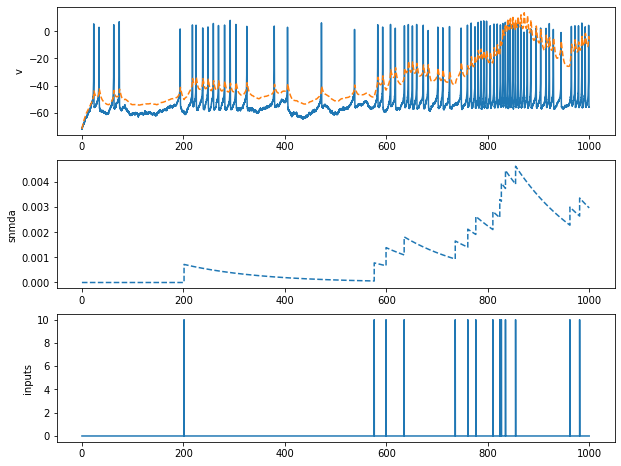

In [ ]:
### Poisson input to neuron
rate = 10
tf = 1000
dt = 0.01
N = round(tf/dt)
t = np.arange(0,tf,dt)
D=0.2#0.2
Dz=2*1.0e-5 ## 2* or 1*
Ne=1

# Input = []
# Amp=0.5
# for i in range(N):
#     Itheta = Izap(i,8,Amp)
#     Igamma = Izap(i,40,1*Amp)
#     Input.append(0.7*Itheta + Igamma)


neuron_list = HHca2(D=D, Gnap = 0.0, Dz=Dz)#)2.5e-5)

v4 = np.empty(N)
v4d = np.empty(N)
s = np.empty(N)
inputs = np.empty(N)

start = time.time()

for i in range(N):
    # Itheta1 = Izap(i,8,3*Amp)
    # Igamma1 = Izap(i,40,0.2*1*Amp)

    # Itheta2 = Izap(i,8,0.2*1*Amp)
    # Igamma2 = Izap(i,40,3*Amp)
    # if(i==10):
    #   neuron_list.add_external()

    if(Ipoisson(rate)): #sync vs async input ):Ipoisson(sig[i])
      neuron_list.add_external()
      inputs[i] = 10
    else:
      inputs[i] = 0

    # neuron_list.eval(-2,-2,0,0,dt, i*dt)
    neuron_list.eval(0.,1,0,0,dt, i*dt)

    v4[i] = neuron_list.v
    v4d[i] = neuron_list.v2
    s[i] = neuron_list.snmda

end = time.time()
print("execution time", end-start)

# plt.plot(v4)
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.plot(t,v4)
plt.plot(t,v4d,'--')
plt.ylabel('v')
plt.subplot(312)
plt.plot(t,s,'--')
plt.ylabel('snmda')
plt.subplot(313)
plt.plot(t,inputs)
plt.ylabel('inputs')

In [ ]:
#@title detecting SS/CS for each neuron but only first spike

SSNe = list([])
CSNe = list([])
dist = 14.0   #distance to distinguish ss/cs
Ne=1
for k in range(Ne):
  vs = v4[k]
  ids, _ = find_peaks(v4>-20) #find the indices of spike
  """searching the CB"""
  sb = []
  for i in range(1,len(ids)):   #backward searching
    if t[ids[i]]-t[ids[i-1]]<dist:
      sb.append(ids[i])
  for i in range(len(ids)-1):   #foward searching
    if t[ids[i+1]]-t[ids[i]]<dist:
      sb.append(ids[i])
  sb = np.sort(sb)              #order
  sb = np.unique(sb)            #... and remove duplicate values   
  """find the SS"""
  ss = ids
  for i in sb:
    ind = np.where(ss == i)
    ss = np.delete(ss,ind)
  """save the SS and CS"""
  SSNe.append(ss)
  CSNe.append(sb)

"""save the first spike of burst"""
CSfs = list([])

for j in range(Ne):
  aux = list([])
  u = CSNe[0]
  aux.append(u[0])
  for k in range(1,len(u)):
    d = t[u[k]]-t[u[k-1]]
    if d>dist:
      aux.append(u[k])
  CSfs. append(aux)

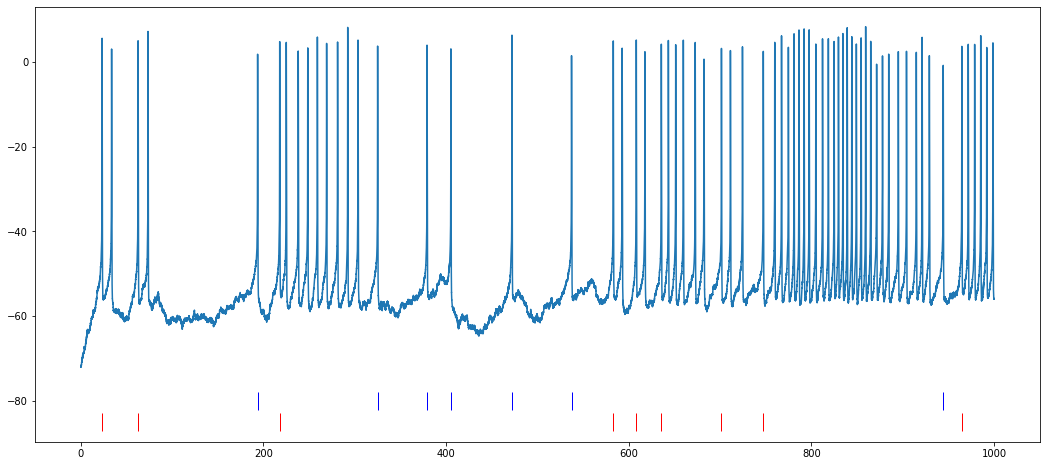

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(t,v4)
i = 0
plt.plot(t[SSNe[i]],-80*np.ones(len(SSNe[i])),linestyle = 'None',marker = '|',color = 'b',markersize = 18,label='SS')
plt.plot(t[CSfs[i]],-85*np.ones(len(CSfs[i])),linestyle = 'None',marker = '|',color = 'r',markersize = 18,label='SB')

execution time 30.568538427352905
execution time 30.458587884902954
execution time 31.816725492477417
execution time 31.207844495773315
execution time 31.425093412399292
execution time 30.58848547935486
execution time 30.441084623336792
execution time 31.533838748931885
execution time 30.55400061607361
execution time 30.76194477081299
execution time 31.356653690338135
execution time 30.716179609298706
execution time 31.37692904472351
execution time 30.84969973564148
execution time 30.77214241027832
execution time 33.194846868515015
execution time 30.669668197631836
execution time 31.120620727539062
execution time 31.186585664749146
execution time 30.776434898376465
execution time 31.5508029460907
execution time 30.665961742401123
execution time 30.65069055557251
execution time 31.65360713005066
execution time 30.678400993347168
execution time 31.318342924118042
execution time 31.041226387023926
execution time 30.701305150985718
execution time 31.487733125686646
execution time 30.589864

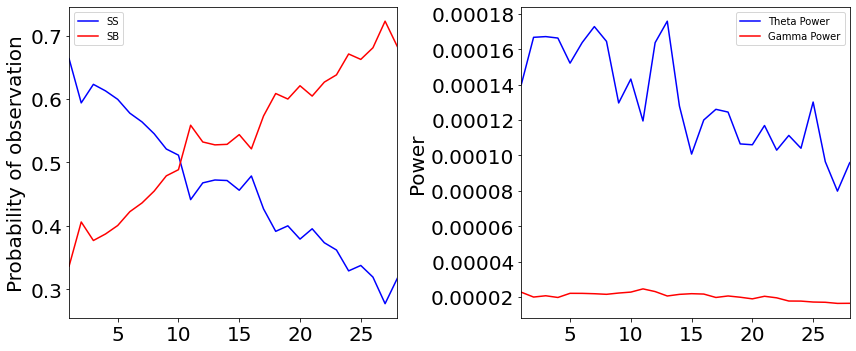

In [ ]:
### Poisson input to neuron

SB = []
SS = []
power_gamma = []
power_theta = []
rate_range=np.arange(1,30,1)
trials=20
for rate in rate_range:
  SB_T=0
  SS_T=0
  power_g=0
  power_t=0
  for trial in np.arange(trials):
        tf = 1000
        dt = 0.01
        N = round(tf/dt)
        t = np.arange(0,tf,dt)
        D=0.2
        Dz=2*1.0e-5
        Ne=1

        neuron_list = HHca2(D=D, Gnap = 0.0, Dz=Dz)#)2.5e-5)

        v4 = np.empty(N)
        v4d = np.empty(N)
        inputs = np.empty(N)

        start = time.time()

        for i in range(N):
            if(Ipoisson(rate)): #sync vs async input ):Ipoisson(sig[i])
              neuron_list.add_external()
              inputs[i] = 10
            else:
              inputs[i] = 0

            neuron_list.eval(0.,1,0,0,dt, i*dt)

            v4[i] = neuron_list.v
            v4d[i] = neuron_list.snmda

        end = time.time()
        print("execution time", end-start)

        ffse = np.abs(np.fft.fft(v4))**2
        ffse = ffse/sum(ffse)
        power_g=power_g+np.mean(ffse[30:90])
        power_t=power_t+np.mean(ffse[3:12])

        SSNe = list([])
        CSNe = list([])
        dist = 14.0   #distance to distinguish ss/cs
        Ne=1
        for k in range(Ne):
          vs = v4[k]
          ids, _ = find_peaks(v4>-20) #find the indices of spike
          """searching the CB"""
          sb = []
          for i in range(1,len(ids)):   #backward searching
            if t[ids[i]]-t[ids[i-1]]<dist:
              sb.append(ids[i])
          for i in range(len(ids)-1):   #foward searching
            if t[ids[i+1]]-t[ids[i]]<dist:
              sb.append(ids[i])
          sb = np.sort(sb)              #order
          sb = np.unique(sb)            #... and remove duplicate values   
          """find the SS"""
          ss = ids
          for i in sb:
            ind = np.where(ss == i)
            ss = np.delete(ss,ind)
          """save the SS and CS"""
          SSNe.append(ss)
          CSNe.append(sb)

        """save the first spike of burst"""
        CSfs = list([])

        for j in range(Ne):
          aux = list([])
          u = CSNe[0]
          aux.append(u[0])
          for k in range(1,len(u)):
            d = t[u[k]]-t[u[k-1]]
            if d>dist:
              aux.append(u[k])
          CSfs. append(aux)

        SB_T = SB_T + len(CSfs[0])
        SS_T = SS_T + len(SSNe[0])

  SB.append(SB_T/trials)
  SS.append(SS_T/trials)

  power_gamma.append(power_g/trials)
  power_theta.append(power_t/trials)

plt.figure(figsize=(12,5))
ax=plt.subplot(121)
plt.plot(rate_range,SS/(np.add(SS,SB)),label='SS',color = 'b')
plt.plot(rate_range,SB/(np.add(SS,SB)),label='SB',color = 'r')
plt.ylabel('Probability of observation')
plt.xlim([1,28])
plt.legend()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(20)
ax=plt.subplot(122)
plt.plot(rate_range,power_theta,label='Theta Power',color = 'b')
plt.plot(rate_range,power_gamma,label='Gamma Power',color = 'r')
plt.ylabel('Power')
plt.xlim([1,28])
plt.legend()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(20)
plt.tight_layout()

plt.savefig(f"{images_dir}/nmda.png")
plt.savefig(f"{images_dir}/nmda.pdf")  

In [ ]:
SS/(np.add(SS,SB))

array([0.66361556, 0.59392265, 0.62315271, 0.61282051, 0.59951456,
       0.5776699 , 0.56390977, 0.54523227, 0.52116402, 0.51145038,
       0.44132653, 0.46774194, 0.47230321, 0.47147147, 0.45614035,
       0.47863248, 0.4267101 , 0.39130435, 0.4       , 0.37906137,
       0.39534884, 0.37333333, 0.3618677 , 0.32894737, 0.3375    ,
       0.31914894, 0.27722772, 0.31696429, 0.35680751])

In [ ]:
SB/(np.add(SS,SB))

array([0.33638444, 0.40607735, 0.37684729, 0.38717949, 0.40048544,
       0.4223301 , 0.43609023, 0.45476773, 0.47883598, 0.48854962,
       0.55867347, 0.53225806, 0.52769679, 0.52852853, 0.54385965,
       0.52136752, 0.5732899 , 0.60869565, 0.6       , 0.62093863,
       0.60465116, 0.62666667, 0.6381323 , 0.67105263, 0.6625    ,
       0.68085106, 0.72277228, 0.68303571, 0.64319249])

In [ ]:
power_theta

[0.00014029186793344396,
 0.00016667922904046507,
 0.0001670840477517962,
 0.00016626202451399508,
 0.0001520902307757635,
 0.0001637372093558443,
 0.00017274133235743006,
 0.00016438338736165533,
 0.00012960649097194902,
 0.00014309780847935558,
 0.00011943044760521708,
 0.00016365167596072626,
 0.00017579331595978174,
 0.0001278514498072771,
 0.00010072736394799663,
 0.0001199714003459529,
 0.00012601184165457116,
 0.0001244560164017677,
 0.00010646763671761877,
 0.0001059865803496259,
 0.00011686967379839658,
 0.00010294176170100655,
 0.00011125906893361091,
 0.00010401975734072295,
 0.00013012334722765505,
 9.644077106905033e-05,
 7.980346684767804e-05,
 9.570075956553233e-05,
 0.0001032733253214635]

In [ ]:
power_gamma

[2.2679191342491277e-05,
 1.9967766383256932e-05,
 2.0695447685819342e-05,
 1.9733927354302496e-05,
 2.2075328769601076e-05,
 2.205081041448393e-05,
 2.185074354748294e-05,
 2.1512693934692742e-05,
 2.2233872731610496e-05,
 2.276830146906846e-05,
 2.4584136775853603e-05,
 2.307049482149229e-05,
 2.0566988838166852e-05,
 2.1486989046545703e-05,
 2.186752534162401e-05,
 2.1660097204119495e-05,
 1.9736215660282193e-05,
 2.0580489279439473e-05,
 1.9872081308734263e-05,
 1.8954627675396767e-05,
 2.0405577050028622e-05,
 1.9528370797502298e-05,
 1.7724231005869817e-05,
 1.7685161130343183e-05,
 1.715481700203474e-05,
 1.7016866541260982e-05,
 1.6388477642367274e-05,
 1.6437776142507626e-05,
 1.622841701783931e-05]

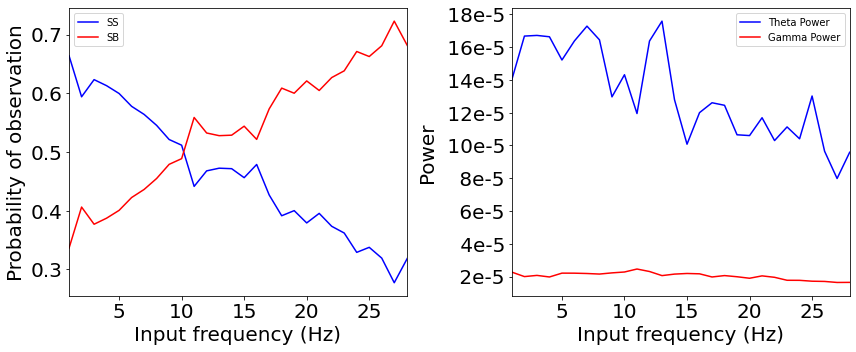

In [ ]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
plt.plot(rate_range,SS/(np.add(SS,SB)),label='SS',color = 'b')
plt.plot(rate_range,SB/(np.add(SS,SB)),label='SB',color = 'r')
plt.ylabel('Probability of observation')
plt.xlabel('Input frequency (Hz)')
plt.xlim([1,28])
plt.legend()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(20)
ax=plt.subplot(122)
plt.plot(rate_range,power_theta,label='Theta Power',color = 'b')
plt.plot(rate_range,power_gamma,label='Gamma Power',color = 'r')
plt.ylabel('Power')
plt.xlabel('Input frequency (Hz)')
plt.xlim([1,28])
plt.legend()
fmt = lambda x, pos: ' {:.0f}e-5'.format((x)*1e5, pos)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(20)
plt.tight_layout()

plt.savefig(f"{images_dir}/nmda_2.png")
plt.savefig(f"{images_dir}/nmda_2.pdf")  